### Calcolo funzioni di autocorrelazione mediando su tutto il database (separatamente per ogni rho) più calcolo std

In [ ]:
import numpy as np
    
def acf(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:] / result[result.size // 2:].max()

def compute_acfs(paths):
    aaacf = np.ndarray(shape=(2,3,2000))
    for path in paths:
        r = float(path[-8:-4])
        print(f'computing acf for r={r}', end=' ')
        db = np.load(path)
        sig_len = len(db[0,0,:])
        n_traj = len(db[:,0,0])
        aacf = np.ndarray(shape=(n_traj,3,sig_len))
        aacf[:,:,:] = 0.0
        for traj, ii in zip(db, range(n_traj)):
            a = traj[0,:]
            b = traj[1,:]
            c = traj[2,:]
            a -= np.mean(a)
            b -= np.mean(b)
            c -= np.mean(c)
            aacf[ii,0,:] = acf(a)
            aacf[ii,1,:] = acf(b)
            aacf[ii,2,:] = acf(c)
        
        aaacf[:,:,:] = 0.0
        aaacf[0,:,:] = np.mean(aacf, axis=0)
        aaacf[1,:,:] = np.std(aacf, axis=0)   
        np.save(f'/scratch/scarpolini/databases/acfe_lorenz_{r:.1f}', aaacf)
        print('Saved!')

def load_acf(r):
    path = f'/scratch/scarpolini/databases/acfe_lorenz_{r:.1f}.npy'
    acf = np.load(path)
    return acf

def load_random_traj(r):
    n = round(np.random.uniform(50000))
    path = f'/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy'
    trajx = np.load(path)[n,0,:]
    return trajx

import glob
paths = glob.glob('/scratch/scarpolini/databases/db_lorenz_*.npy')
paths = sorted(paths, key=lambda x : float(x[-8:-4]))
path = paths
compute_acfs(path)

### plotto risultati acf e std per una rho

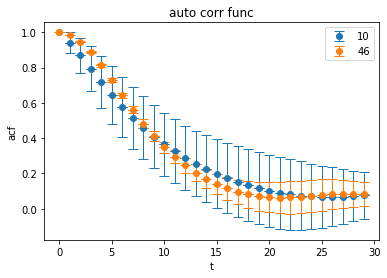

In [12]:
def plot_acfs(rv, xlim):
    import matplotlib.pyplot as plt
    for r in rv:
        mm = load_acf(r)[0,0,:]
        ss = load_acf(r)[1,0,:]
        l, caps, c = plt.errorbar(range(xlim),mm[:xlim],yerr=ss[:xlim], lw=0, marker='o', ms=6,
                                  elinewidth=1, uplims=True, lolims=True, capsize=5, label=str(r))
        for cap in caps:
            cap.set_marker("_")
        plt.xlabel("t")
        plt.ylabel("acf")
    plt.title('auto corr func')
    plt.legend()
    plt.show()

plot_acfs([10, 46],30)

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


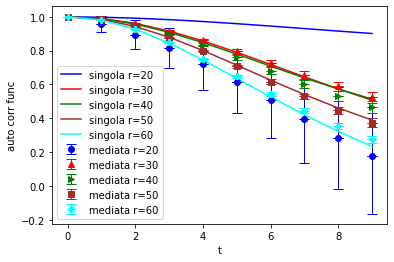

In [22]:
import numpy as np
import matplotlib.pyplot as plt

xlim = 10
rv = [20,30,40, 50, 60]
markers = ['o', '^', '>', 's', 'P', '*']
colors = ['blue', 'red', 'green', 'brown', 'cyan', 'purple']
### mediati
for i, r in enumerate(rv) :
    pathh = f'/scratch/scarpolini/databases/acfe_lorenz_{r:.1f}.npy'
    aacf = load_acf(r)[0,0,:]
    acfe = load_acf(r)[1,0,:]
    l, caps, c = plt.errorbar(range(xlim),aacf[:xlim],yerr=acfe[:xlim], label='mediata r='+str(r), lw=0, c=colors[i], 
                              marker=markers[i], ms=6, elinewidth=1, uplims=True, lolims=True, capsize=5)
    for cap in caps:
        cap.set_marker("_")

### traiettorie singole
for i, r in enumerate(rv) :
    trajx = load_random_traj(r)
    acfx = acf(trajx)
    plt.plot(range(xlim),acfx[:xlim], label='singola r='+str(r), c=colors[i])
        
plt.xlabel("t")
plt.ylabel("auto corr func")
plt.legend()
plt.savefig(f'plots/acf_comparation{rv}.png', dpi=220, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
plt.show()

### Exit time $\bar{t}_s$
$$
\bar t _s := \bar t \quad t.c. \quad acf(\bar t) = s
$$

In [ ]:
import numpy as np
    
def acf(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:] / result[result.size // 2:].max()

def exit_time(paths, soglia):
    for jj, path in enumerate(paths):
        etx = []
        ety = []
        etz = []
        r = float(path[-8:-4])
        print(f'computing exit time for r={r}, {0:5}', end='\r')
        db = np.load(path)
        sig_len = len(db[0,0,:])
        n_traj = len(db[:,0,0])
        for traj, ii in zip(db, range(n_traj)):
            if ii == 49999: print(f'computing exit time for r={r}, {ii:5}', end=' ')
            else: print(f'computing exit time for r={r}, {ii:5}', end='\r')
            a = traj[0,:]
            b = traj[1,:]
            c = traj[2,:]
            a -= np.mean(a)
            b -= np.mean(b)
            c -= np.mean(c)
            acfx = acf(a)
            acfy = acf(b)
            acfz = acf(c)
            for t, y in enumerate(acfx):
                if y < soglia :
                    etx.append(t)
                    break
            for t, y in enumerate(acfy):
                if y < soglia :
                    ety.append(t)
                    break
            for t, y in enumerate(acfz):
                if y < soglia :
                    etz.append(t)
                    break
        np.save(f'/scratch/scarpolini/databases/exit_time_{soglia:.2f}_lorenz_{r:.1f}', [etx, ety, etz])
        print('Saved!')

def load_acf(r):
    path = f'/scratch/scarpolini/databases/acfe_lorenz_{r:.1f}.npy'
    acf = np.load(path)
    return acf

def load_random_traj(r):
    n = round(np.random.uniform(50000))
    path = f'/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy'
    trajx = np.load(path)[n,0,:]
    return trajx

import glob
paths = glob.glob('/scratch/scarpolini/databases/db_lorenz_*.npy')
paths = sorted(paths, key=lambda x : float(x[-8:-4]))
path = paths
exit_time(path,0.5)

computing exit time for r=10.0, 49999 Saved!
computing exit time for r=11.0, 49999 Saved!
computing exit time for r=12.0, 49999 Saved!
computing exit time for r=13.0, 49999 Saved!
computing exit time for r=14.0, 49999 Saved!
computing exit time for r=15.0, 49999 Saved!
computing exit time for r=16.0, 49999 Saved!
computing exit time for r=17.0, 49999 Saved!


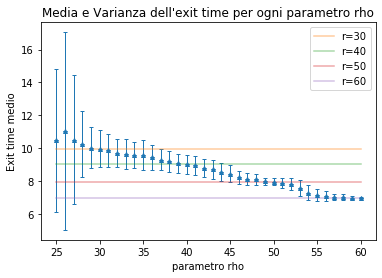

In [125]:
import matplotlib.pyplot as plt

soglia = 0.5

rv = range(25,61,1)
paths = [f'/scratch/scarpolini/databases/exit_time_{soglia:.2f}_lorenz_{r:.1f}.npy' for r in rv]
et = [np.load(path) for path in paths]

#bins=[5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5]
labels = [str(r) for r in rv]
#plt.hist([x[0] for x in et], bins=bins,label=labels, density=True, histtype='bar')
#plt.legend()
#plt.show()
means = [np.mean(x) for x in [x[0] for x in et]]
stds = [np.std(x) for x in [x[0] for x in et]]
my_et = [et[5],et[15],et[25],et[35]]
my_labels = [f"r={r}" for r in [rv[5],rv[15],rv[25],rv[35]]]
my_means = [np.mean(x) for x in [x[0] for x in my_et]]

l, caps, c = plt.errorbar(rv, means, stds, lw=0, marker='^', ms=4, elinewidth=1, uplims=True, lolims=True, capsize=2)
for cap in caps:
    cap.set_marker("_")
for i in range(len(my_means)): plt.plot([rv[0],rv[-1]],[my_means[i],my_means[i]],alpha=0.4, label=my_labels[i])
plt.xlabel('parametro rho')
plt.ylabel('Exit time medio')
plt.title("Media e Varianza dell'exit time per ogni parametro rho")
plt.legend()
plt.savefig("plots/exit_time_medio.png", dpi=220, format='png')
plt.show()


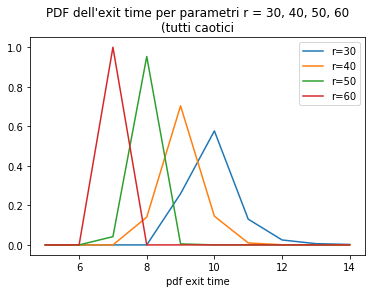

In [126]:
import matplotlib.pyplot as plt

soglia = 0.5

rv = range(30,70,10)
paths = [f'/scratch/scarpolini/databases/exit_time_{soglia:.2f}_lorenz_{r:.1f}.npy' for r in rv]
et = [np.load(path) for path in paths]

bins=[4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5]
axis = [np.mean([bins[i],bins[i+1]]) for i in range(0,len(bins)-1)]
labels = [f'r={r}' for r in rv]
hists = [np.histogram(a[0], bins=bins, density=True)[0] for a in et]
for hist,label in zip(hists,labels): plt.plot(axis, hist, label=label)
plt.legend()
plt.xlabel('exit time')
plt.xlabel('pdf exit time')
plt.title("PDF dell'exit time per parametri r = 30, 40, 50, 60\n(tutti caotici")
plt.savefig("plots/pdf_exit_time.png", dpi=220, format='png')
plt.show()